# Handwritten Text Recognition - OCR - CNN

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import random
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [2]:
# Data Acquisition
DATA = "../data/raw"
LETS = list("SINO")
NUM_LETS = len(LETS)
IMG_SIZE = 100
model_path = "../data/model"
model_name = "model"

In [3]:
# Turns images into black and white
def black_and_white(image, threshold):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((2,2))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return closing

In [4]:
# Loading all letter images, resizing and labeling them
def load_letters(path, letters_list, img_size):
    letters = []
    # Looping through each letter folder
    for let in letters_list:
        images = os.listdir(os.path.join(path, let))
        # Looping through each image within a specific letter folder
        for pic in images:
            # Reading letter image, turning it to gray scale and resizing it
            img = cv2.imread(os.path.join(path, let, pic))
            resized = cv2.resize(img, (img_size, img_size))
            
            thresh = black_and_white(resized, 120)
            
            # Saving letter image array and target into a list
            letters.append([thresh, letters_list.index(let)])
            #letters.append([threshold, let])
    
    return letters
        
letters = load_letters(DATA, LETS, IMG_SIZE)
print(len(letters))

120


In [5]:
# Checking how many images were read per letter
def check_loaded_data(loaded_letters_list, individual_letters_list):
    y = [target[1] for target in loaded_letters_list]
    res = [[letter, y.count(individual_letters_list.index(letter))] for letter in individual_letters_list]
    #res = [[letter, y.count(letter)] for letter in individual_letters_list]
    print(res)

check_loaded_data(letters, LETS)

[['S', 30], ['I', 30], ['N', 30], ['O', 30]]


In [6]:
# Checking loaded images
def shuffle(list_to_shuffle):
    random.shuffle(list_to_shuffle)
    return list_to_shuffle

shuffled = shuffle(letters)
print(len(shuffled))

120


In [7]:
def prep_data(training_data):
    """
    Preparing the data that will be used to feed the model
    :param training_data: 
    :return: 
    """
    X, y = [], []
    # Splitting data into traning data (X) and its label or target (y)
    for features, label in training_data:
        X.append(features)
        y.append(label)
        
    # Converting y list into a categorical array, 0 and 1. It will have as many columns as letters to train
    y = tf.keras.utils.to_categorical(y, len(LETS))
    
    # Converting X list into a keras array ready to be used to train the model
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) # 1 grayscale, 3 colored images
    
    # Normalizing training data
    X = tf.keras.utils.normalize(X, axis=1)
    print(X.shape, y.shape)

    return X, y

X, y = prep_data(shuffled)

(120, 100, 100, 1) (120, 4)


In [8]:
def model_setup(X, y, letters_list):

    # Model's name
    NAME = f"OCR-CNN-{int(time.time())}"
    print(NAME)

    # Model instantiation and layers definition
    model = Sequential() # instatiating the NN

    # Adding first 2D convolution layer
    model.add(Conv2D(64, (3,3), input_shape=X.shape[1:], activation="relu")) # X.shape[1:] → (100, 100, 1)
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Adding second 2D convolution layer
    model.add(Conv2D(64, (3,3), activation="relu"))# don't have to specify input shape in additional layers.
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Adding third 2D convolution layer
    model.add(Conv2D(64, (3,3), activation="relu"))# don't have to specify input shape in additional layers.
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flattening before passing it to the dense layer
    model.add(Flatten())

    # Adding output layer, as many units as letters there are, activation softmax
    model.add(Dense(len(letters_list), activation="softmax"))

    # Setting up tensorboard logs
    tb = TensorBoard(log_dir=f"../data/logs/{NAME}")

    # Model parameters
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Model summary
    model.summary()
    
    # Model fitting
    hist = model.fit(X, y, batch_size=16, epochs=10, validation_split=0.2, callbacks=[tb])
    
    return model, hist
    
model, hist = model_setup(X, y, LETS)

OCR-CNN-1586277114
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6

Model perfomance chart was successfully saved at: 


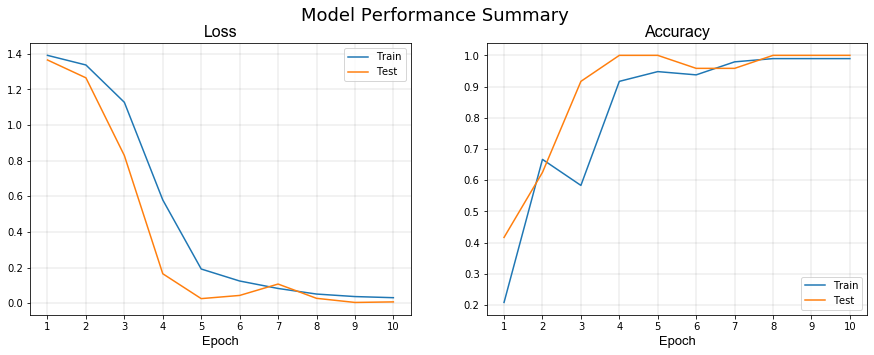

In [9]:
def plot_performance(hist):

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle("Model Performance Summary", fontsize=18)
    
    x_ticks = np.arange(1, len(hist.history["loss"]) + 1)
    
    label_font = {"fontname" : "Arial", "fontsize": 13}
    title_font = {"fontname" : "Arial", "fontsize": 16}
    
    axes[0].set_title("Loss", fontdict=title_font)
    axes[0].set_xlabel("Epoch", fontdict=label_font)
    axes[0].set_xticks(np.arange(len(x_ticks)))
    axes[0].set_xticklabels(x_ticks)
    axes[0].plot(hist.history["loss"], label="Train")
    axes[0].plot(hist.history["val_loss"], label="Test")
    axes[0].grid(True, color="black", linewidth=0.1)
    axes[0].legend()

    axes[1].set_title("Accuracy", fontdict=title_font)
    axes[1].set_xlabel("Epoch", fontdict=label_font)
    axes[1].set_xticks(np.arange(len(x_ticks)))
    axes[1].set_xticklabels(x_ticks)
    axes[1].plot(hist.history["accuracy"], label="Train")
    axes[1].plot(hist.history["val_accuracy"], label="Test")
    axes[1].legend(loc=4)
    axes[1].grid(True, color="black", linewidth=0.1)
    
    try:
        plt.savefig("performance.png")
        print("Model perfomance chart was successfully saved at: ")
    except Exception as e:
        print("Error saving model chart")

plot_performance(hist)

In [10]:
loss, acc = model.evaluate(X, y)

120/120 [==============================] - 1s 5ms/sample - loss: 0.0224 - accuracy: 0.9917


In [11]:
# saving the model
def save_model_h5(model, model_path, model_name):
    model.save(os.path.join(model_path, f"{model_name}.h5"))
    print(f"Saved model to {model_path}/{model_name}.h5")
    
# loading the model
def load_model_h5(model_path, model_name):
    try:
        # Loading H5 file
        print(os.path.join(model_path, f"{model_name}.h5"))
        loaded_model = load_model(os.path.join(model_path, f"{model_name}.h5"))
        print("Model loaded successfully")
        return loaded_model
    except  Exception as e:
        print("Model couldn't be loaded. Did you import keras load_model function?")

save_model_h5(model, model_path, model_name)
loaded_model = load_model_h5(model_path, model_name)

Saved model to ../data/model/model.h5
../data/model/model.h5
Model loaded successfully


/home/nicolas/miniconda3/envs/deep_envs/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[[1. 0. 0. 0.]]')

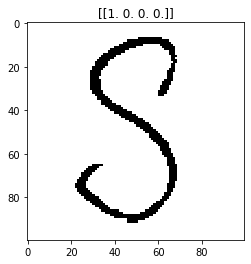

(1, 100, 100, 1)


Text(0.5, 1.0, '[[0. 1. 0. 0.]]')

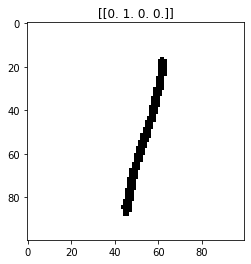

(1, 100, 100, 1)


Text(0.5, 1.0, '[[0. 0. 1. 0.]]')

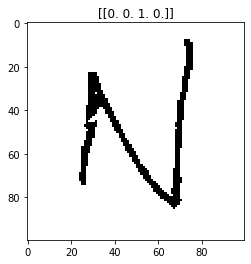

(1, 100, 100, 1)


Text(0.5, 1.0, '[[0. 0. 0. 1.]]')

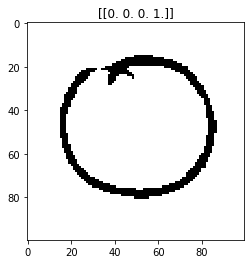

(1, 100, 100, 1)


In [12]:
testpath = "../data/test"
testimages = os.listdir(testpath)
for test in testimages:
    img = cv2.imread(os.path.join(testpath, test))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
    _, threshold = cv2.threshold(resized, 130, 255, cv2.THRESH_BINARY)

    plt.imshow(threshold, cmap="gray")
    
    threshold = np.array(threshold).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    
    p = model.predict(threshold)
    plt.title(p)
    plt.show()
    print(threshold.shape)